In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
from brmspy.brms import bf
from brmspy import brms

[brmspy][register_dataclasses][WARNING] [<class 'brmspy.session.types.SexpWrapper'>, <class 'brmspy.types.PriorSpec'>, <class 'brmspy.types.GenericResult'>, <class 'brmspy.types.FitResult'>, <class 'brmspy.types.PosteriorEpredResult'>, <class 'brmspy.types.PosteriorPredictResult'>, <class 'brmspy.types.LogLikResult'>, <class 'brmspy.types.PosteriorLinpredResult'>, <class 'brmspy.types.FormulaPart'>, <class 'brmspy.types.FormulaResult'>, <class 'brmspy.types.SummaryResult'>, <class 'brmspy.types.LooResult'>, <class 'brmspy.types.LooCompareResult'>, <class 'brmspy.types.RListVectorExtension'>]


In [3]:
if False:
    with brms.manage() as ctx:
        ctx.install_brms(use_prebuilt=True)
        ctx.install_rpackage("MCMCglmm")

In [4]:
r_matrix = brms.call(
    "matrix",
    [1,2,3, 11,12,13],
    nrow = 2, ncol = 3,
    byrow = True,
    dimnames = [
        ["row1", "row2"],
        ["C.1", "C.2", "C.3"]
    ]
)

[brmspy][register_dataclasses][WARNING] [<class 'brmspy.session.types.SexpWrapper'>, <class 'brmspy.types.PriorSpec'>, <class 'brmspy.types.GenericResult'>, <class 'brmspy.types.FitResult'>, <class 'brmspy.types.PosteriorEpredResult'>, <class 'brmspy.types.PosteriorPredictResult'>, <class 'brmspy.types.LogLikResult'>, <class 'brmspy.types.PosteriorLinpredResult'>, <class 'brmspy.types.FormulaPart'>, <class 'brmspy.types.FormulaResult'>, <class 'brmspy.types.SummaryResult'>, <class 'brmspy.types.LooResult'>, <class 'brmspy.types.LooCompareResult'>, <class 'brmspy.types.RListVectorExtension'>]
[brmspy][_autoload] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][_autoload] lib paths are ['/Users/sebastian/.brmspy/environment/default/Rlib', '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][_autoload] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos

In [5]:
r_matrix

,C.1,C.2,C.3
row1,1,11,2
row2,12,3,13


In [6]:
r_matrix

,C.1,C.2,C.3
row1,1,11,2
row2,12,3,13


In [7]:
data = brms.get_brms_data("epilepsy")
data

,Age,Base,Trt,patient,visit,count,obs,zAge,zBase
1,31.0,11.0,1,1,1,5.0,1,0.424995,-0.757173
2,30.0,11.0,1,2,1,3.0,2,0.265284,-0.757173
3,25.0,6.0,1,3,1,2.0,3,-0.533274,-0.944403
4,36.0,8.0,1,4,1,4.0,4,1.223553,-0.869511
5,22.0,66.0,1,5,1,7.0,5,-1.012408,1.302363
...,...,...,...,...,...,...,...,...,...
232,32.0,16.0,2,55,4,3.0,232,0.584707,-0.569942
233,26.0,22.0,2,56,4,8.0,233,-0.373562,-0.345266
234,21.0,25.0,2,57,4,1.0,234,-1.172120,-0.232927
235,36.0,13.0,2,58,4,0.0,235,1.223553,-0.682281


In [8]:
r1 = brms.brm(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    data=data,
    family="poisson",
    warmup=500,
    iter=1000,
    chains=4
)


[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[brmspy][worker_main] Fit done!


In [9]:
r1

FitResult(r= Family: poisson 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.58      0.07     0.46     0.74 1.01      408      599

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.00      0.27     1.45     2.55 1.01      351      612
zAge          0.09      0.09    -0.09     0.27 1.01      349      582
zBase         0.63      0.27     0.11     1.17 1.01      258      484
Trt          -0.25      0.16    -0.59     0.08 1.01      330      664
zBase:Trt     0.06      0.17    -0.27     0.39 1.01      267      549

Draws were sampled using sample(hmc). For ea

In [10]:
brms.summary(r1)

 Family: poisson 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.58      0.07     0.46     0.74 1.01      408      599

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.00      0.27     1.45     2.55 1.01      351      612
zAge          0.09      0.09    -0.09     0.27 1.01      349      582
zBase         0.63      0.27     0.11     1.17 1.01      258      484
Trt          -0.25      0.16    -0.59     0.08 1.01      330      664
zBase:Trt     0.06      0.17    -0.27     0.39 1.01      267      549

Draws were sampled using sample(hmc). For each parameter

In [11]:
import arviz as az

<Axes: xlabel='count'>

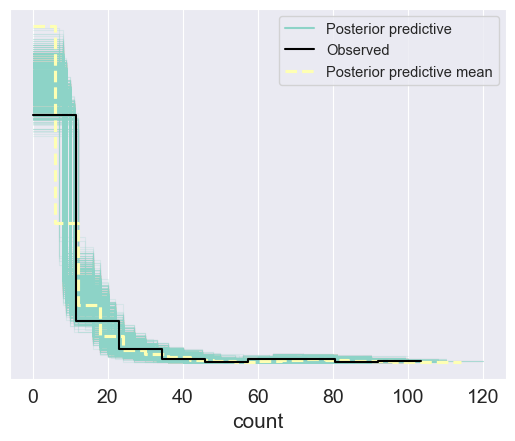

In [12]:
az.plot_ppc(r1.idata)